In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import function as f
import re

In [135]:
def create_completion_df(csv_data):
    columns = ["Prev Truck Number", "Now Truck Number", "alpha_1", "alpha_2", "alpha_3"] + csv_data[0][1][0]

    data_list = []

    for file_name, file_data in csv_data:
        
        # Extract numbers after "Truck_"
        truck_numbers = re.findall(r'Truck_(\d+)', file_name)
        truck_numbers[0], truck_numbers[1] = truck_numbers[1], truck_numbers[0]
        alphas_match = re.search(r"LP_(\d+)_(\d+)_(\d+)", file_name)
        
        if alphas_match:
            alpha1 = int(alphas_match.group(1))
            alpha2 = int(alphas_match.group(2))
            alpha3 = int(alphas_match.group(3))
            
            alphas = [alpha1, alpha2, alpha3]
        
        for row in file_data[1:]:
            # print(row)
            row[4:] = [float(value) for value in row[4:]]
            new_row = truck_numbers + alphas + row
            data_list.append(new_row)

    df = pd.DataFrame(data_list, columns=columns)

    return df

In [136]:
def classify_by_truck_id(_df):
    # Grouping by alpha_1, alpha_2, and alpha_3
    grouped_df = _df.groupby(['alpha_1', 'alpha_2', 'alpha_3'])

    selected_rows = []

    for (alpha_1, alpha_2, alpha_3), group in grouped_df:
        
        
        # Filter the group to select rows with Truck_id less than 100#
        less_than_100 = group[group['Truck_id'].str.extract(r'Truck-(\d+)', expand = False).astype(int) < 100]

        # Select row with the largest Total Time for Truck_id less than 100
        if not less_than_100.empty:
            max_time_row_lt_100 = less_than_100.loc[less_than_100['Total Time'].idxmax()]
            selected_rows.append(max_time_row_lt_100)
        
        # Select rows with the largest Total Time for Truck_id greater than or equal to 100
        greater_than_100 = group[group['Truck_id'].str.extract(r'Truck-(\d+)', expand = False).astype(int) >= 100]

        if not greater_than_100.empty:
            # max_time_rows_gt_100 = greater_than_100.nlargest(2, 'Total Time')
            max_time_rows_gt_100 = greater_than_100.loc[greater_than_100['Total Time'].idxmax()]
            selected_rows.append(max_time_rows_gt_100)

    # Create a new DataFrame from the selected rows
    new_df = pd.DataFrame(selected_rows, columns=_df.columns)

    # Print the selected DataFrame
    new_df.reset_index(drop=True, inplace=True)
    
    return new_df

In [162]:
def get_mean_by_truck_id(_df):
    grouped_df = _df.groupby(['alpha_1', 'alpha_2', 'alpha_3'])

    prev_truck_num = _df['Prev Truck Number'].unique().tolist()
    now_truck_num = _df['Now Truck Number'].unique().tolist()
    
    column_names = ['Prev Truck Number', 'Now Truck Number', 'alpha_1', 'alpha_2', 'alpha_3', 'less than 100','mean Completion Time']
    selected_rows = []

    for (alpha_1, alpha_2, alpha_3), group in grouped_df:
        less_than_100 = group[group['Truck_id'].str.extract(r'Truck-(\d+)', expand=False).astype(int) < 100]
        greater_than_100 = group[group['Truck_id'].str.extract(r'Truck-(\d+)', expand=False).astype(int) >= 100]
        
        if not less_than_100.empty:
            mean_time_lt_100 = less_than_100['Total Time'].mean()
            mean_time_lt_100_df = pd.DataFrame([prev_truck_num + now_truck_num + [alpha_1, alpha_2, alpha_3, "true", mean_time_lt_100]], columns=column_names)
            selected_rows.append(mean_time_lt_100_df)
        
        if not greater_than_100.empty:
            mean_time_gt_100 = greater_than_100['Total Time'].mean()
            mean_time_gt_100_df = pd.DataFrame([prev_truck_num + now_truck_num +[alpha_1, alpha_2, alpha_3, "false", mean_time_gt_100]], columns=column_names)
            selected_rows.append(mean_time_gt_100_df)

    new_df = pd.concat(selected_rows, ignore_index=True)
    
    return new_df


In [163]:
def draw_plot_completion_df(_df, _title_name, _x_label, _y_label, _legend_list):
    # index가 짝수인 행만 선택 
    # 이전에 스케줄링 된 트럭
    x_value_1 = _df.iloc[::2, :]["alpha_1"]
    y_value_1 = _df.iloc[::2, :]["Total Time"]

    # 현재 스케줄링 대상 트럭
    x_value_2 = _df.iloc[1::2, :]["alpha_1"]
    y_value_2 = _df.iloc[1::2, :]["Total Time"]

    # 그래프 그리기
    plt.figure(figsize=(6,3))
    plt.plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')
    plt.plot(x_value_2, y_value_2 , marker='o', linestyle='-', color = 'crimson')
    plt.title(_title_name, fontsize=11, ha='center')

    plt.xlabel(_x_label, fontsize=9)
    plt.ylabel(_y_label, fontsize=9)

    _y_values = np.concatenate((y_value_1, y_value_2), axis=None)
    plt.ylim(int(_y_values.min()) - 10, int(_y_values.max()) + 10)
    # plt.yticks(range(0, int(_y_values.max()) + 100, 100))

    plt.legend(_legend_list, loc='upper right')
    plt.grid(True, axis='y')
    plt.show()


In [164]:
def Create_subplot(_dfs, _x_label, _y_label, _title, _x_col_name, _y_col_name, row_num, col_num, fig_size):
    
    f, axes = plt.subplots(row_num, col_num)
    
    # 격자 크기 설정
    f.set_size_inches(fig_size)

    # 격자 여백 설정
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    
    row_index = 0
    col_index = 0
    
    for i in range(len(_dfs)):
        
        x_value_1 = _dfs[i].iloc[::2, :][_x_col_name]
        y_value_1 = _dfs[i].iloc[::2, :][_y_col_name]

        # 현재 스케줄링 대상 트럭
        x_value_2 = _dfs[i].iloc[1::2, :][_x_col_name]
        y_value_2 = _dfs[i].iloc[1::2, :][_y_col_name]
        
        if row_num == 1:
            plt.subplot(1, col_num, col_index + 1)
            plt.plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')
            plt.plot(x_value_2, y_value_2 , marker='o', linestyle='-', color = 'crimson')
            plt.xlabel(_x_label, fontsize=9, ha='center')
            plt.ylabel(_y_label, fontsize=9)
            # x축 10 단위로 표시
            plt.xticks(range(x_value_1.min(), x_value_1.max() + 10, 10))
            plt.title("Completion Time by alpha_1 (prev_" + _dfs[i]['Prev Truck Number'].unique() + "_now_" + _dfs[i]['Now Truck Number'].unique() + ")", fontsize=9, ha='center')
            
        else:
            # x축 10 단위로 표시
            axes[row_index, col_index].set_xticks(range(x_value_1.min(), x_value_1.max() + 10, 10))
            axes[row_index, col_index].plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')
            axes[row_index, col_index].plot(x_value_2, y_value_2 , marker='o', linestyle='-', color = 'crimson')
            
            # title_name = "Completion Time by alpha_1 (prev_20_now_20)"
            title_name = _title + "(prev_" + _dfs[i]['Prev Truck Number'].unique() + "_now_" + _dfs[i]['Now Truck Number'].unique() + ")"
            
            axes[row_index, col_index].set_xlabel(_x_label, fontsize=9, ha='center')
            axes[row_index, col_index].set_ylabel(_y_label, fontsize=9)
            axes[row_index, col_index].set_title(title_name, fontsize=9, ha='center')

        col_index += 1
        if(col_index == col_num):
            col_index = 0
            row_index += 1
        
    plt.show()

In [165]:
file_path = 'completion_time/now_20_prev_20'

prev_20_now_20_data = f.load_csv_files_in_folder(file_path)

prev_20_now_20_data_df = create_completion_df(prev_20_now_20_data)
classified_prev_20_now_20_df = classify_by_truck_id(prev_20_now_20_data_df)
classified_prev_20_now_20_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,Truck_id,Route_id,Origin,Destination,Total Time,PickupSta AT,DropSta AT
0,20,20,0,0,100,Truck-19,Route-19,(425.0 0.0 -5.5),(375.0 0.0 50.0),441.016,41.288,68.712
1,20,20,0,0,100,Truck-111,Route-111,(675.0 0.0 5.5),(125.0 0.0 0.0),448.088,76.552,66.520
2,20,20,10,80,10,Truck-15,Route-15,(675.0 0.0 5.5),(125.0 0.0 50.0),456.208,50.936,84.272
3,20,20,10,80,10,Truck-116,Route-116,(425.0 0.0 -5.5),(125.0 0.0 0.0),436.304,66.248,64.048
4,20,20,20,70,10,Truck-15,Route-15,(675.0 0.0 5.5),(125.0 0.0 50.0),449.120,50.560,81.520


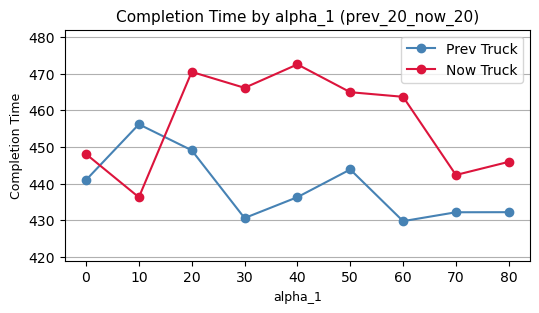

In [166]:
x_label = "alpha_1"
y_label = "Completion Time"

title_name = "Completion Time by alpha_1 (prev_20_now_20)"
legend_list = ["Prev Truck", "Now Truck"]

draw_plot_completion_df(classified_prev_20_now_20_df, title_name, x_label, y_label, legend_list)

### prev 20 now 40

In [167]:
file_path = 'completion_time/now_40_prev_20'

prev_20_now_40_data = f.load_csv_files_in_folder(file_path)

prev_20_now_40_data_df = create_completion_df(prev_20_now_40_data)

classified_prev_20_now_40_df = classify_by_truck_id(prev_20_now_40_data_df)
classified_prev_20_now_40_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,Truck_id,Route_id,Origin,Destination,Total Time,PickupSta AT,DropSta AT
0,20,40,0,0,100,Truck-15,Route-15,(675.0 0.0 5.5),(125.0 0.0 100.0),464.280,50.808,93.456
1,20,40,0,0,100,Truck-123,Route-123,(675.0 0.0 5.5),(125.0 0.0 100.0),488.488,115.024,68.432
2,20,40,10,80,10,Truck-14,Route-14,(675.0 0.0 5.5),(125.0 0.0 150.0),450.808,46.448,77.280
3,20,40,10,80,10,Truck-132,Route-132,(175.0 0.0 105.5),(625.0 0.0 0.0),479.592,51.384,121.184
4,20,40,20,70,10,Truck-15,Route-15,(675.0 0.0 5.5),(125.0 0.0 50.0),475.840,54.320,104.352


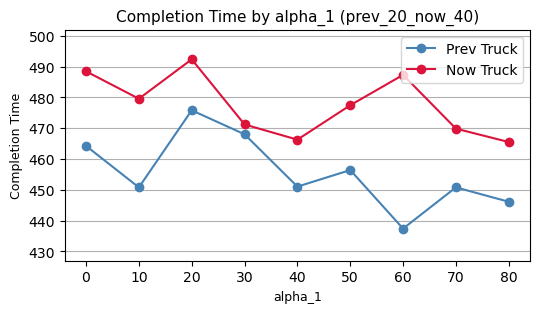

In [168]:
x_label = "alpha_1"
y_label = "Completion Time"

title_name = "Completion Time by alpha_1 (prev_20_now_40)"
legend_list = ["Prev Truck", "Now Truck"]

draw_plot_completion_df(classified_prev_20_now_40_df, title_name, x_label, y_label, legend_list)

### Prev 20, now 30

In [169]:
file_path = 'completion_time/now_30_prev_20'

prev_20_now_30_data = f.load_csv_files_in_folder(file_path)

prev_20_now_30_data_df = create_completion_df(prev_20_now_30_data)

classified_prev_20_now_30_df = classify_by_truck_id(prev_20_now_30_data_df)
classified_prev_20_now_30_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,Truck_id,Route_id,Origin,Destination,Total Time,PickupSta AT,DropSta AT
0,20,30,0,0,100,Truck-18,Route-18,(425.0 0.0 155.5),(625.0 0.0 0.0),426.176,37.624,80.560
1,20,30,0,0,100,Truck-110,Route-110,(175.0 0.0 105.5),(625.0 0.0 50.0),468.920,47.288,114.624
2,20,30,10,80,10,Truck-0,Route-0,(425.0 0.0 -5.5),(375.0 0.0 200.0),408.928,47.384,56.544
3,20,30,10,80,10,Truck-100,Route-100,(175.0 0.0 55.5),(625.0 0.0 100.0),510.408,58.640,146.720
4,20,30,20,70,10,Truck-12,Route-12,(675.0 0.0 5.5),(375.0 0.0 200.0),431.936,23.896,95.960


In [170]:
file_path = 'completion_time/now_30_prev_30'

prev_30_now_30_data = f.load_csv_files_in_folder(file_path)

prev_30_now_30_data_df = create_completion_df(prev_30_now_30_data)

classified_prev_30_now_30_df = classify_by_truck_id(prev_30_now_30_data_df)
classified_prev_30_now_30_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,Truck_id,Route_id,Origin,Destination,Total Time,PickupSta AT,DropSta AT
0,30,30,0,0,100,Truck-27,Route-27,(175.0 0.0 55.5),(375.0 0.0 50.0),448.976,43.448,93.408
1,30,30,0,0,100,Truck-100,Route-100,(175.0 0.0 105.5),(625.0 0.0 150.0),515.136,47.872,162.224
2,30,30,10,80,10,Truck-27,Route-27,(175.0 0.0 55.5),(375.0 0.0 50.0),445.776,43.424,90.240
3,30,30,10,80,10,Truck-102,Route-102,(175.0 0.0 5.5),(625.0 0.0 150.0),470.488,59.208,105.264
4,30,30,20,70,10,Truck-7,Route-7,(175.0 0.0 55.5),(375.0 0.0 50.0),442.704,39.536,93.136


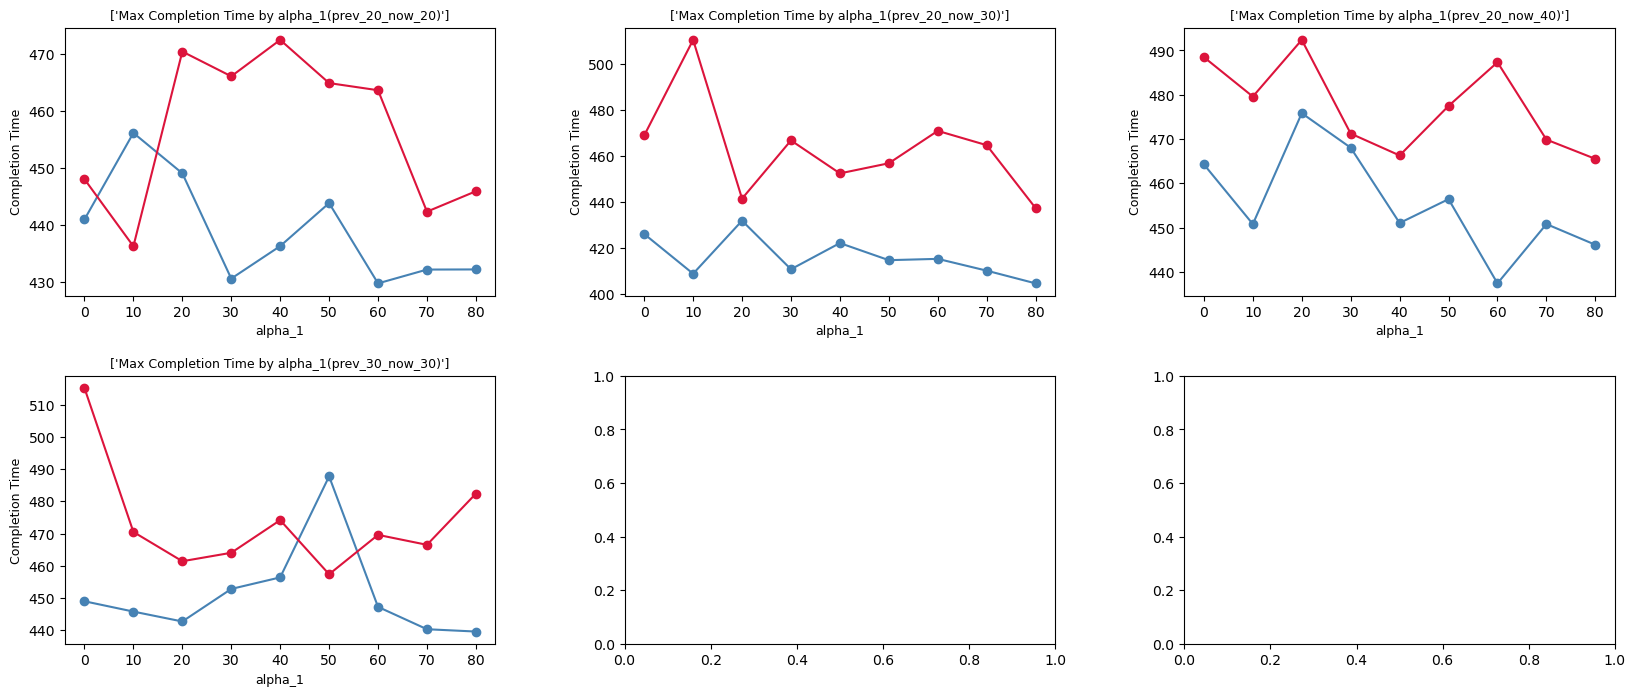

In [171]:
dfs = [classified_prev_20_now_20_df, classified_prev_20_now_30_df, classified_prev_20_now_40_df, classified_prev_30_now_30_df]
x_label = "alpha_1"
y_label = "Completion Time"
title = "Max Completion Time by alpha_1"

x_col_name = "alpha_1"
y_col_name = "Total Time"

Create_subplot(dfs, x_label, y_label, title, x_col_name, y_col_name, 2, 3, (20, 8))


In [172]:
prev_20_now_20_data_mean_df = get_mean_by_truck_id(prev_20_now_20_data_df)
prev_20_now_20_data_mean_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,less than 100,mean Completion Time
0,20,20,0,0,100,true,390.3252
1,20,20,0,0,100,false,382.0928
2,20,20,10,80,10,true,388.4384
3,20,20,10,80,10,false,378.9224
4,20,20,20,70,10,true,388.6572


In [173]:
prev_20_now_30_data_mean_df = get_mean_by_truck_id(prev_20_now_30_data_df)
prev_20_now_30_data_mean_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,less than 100,mean Completion Time
0,20,30,0,0,100,true,385.373600
1,20,30,0,0,100,false,393.922933
2,20,30,10,80,10,true,381.348800
3,20,30,10,80,10,false,398.971467
4,20,30,20,70,10,true,392.442000


In [174]:
prev_20_now_40_data_mean_df = get_mean_by_truck_id(prev_20_now_40_data_df)
prev_20_now_40_data_mean_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,less than 100,mean Completion Time
0,20,40,0,0,100,true,406.1880
1,20,40,0,0,100,false,406.3261
2,20,40,10,80,10,true,393.1412
3,20,40,10,80,10,false,403.4050
4,20,40,20,70,10,true,410.4420


In [175]:
prev_30_now_30_data_mean_df = get_mean_by_truck_id(prev_30_now_30_data_df)
prev_30_now_30_data_mean_df.head()

,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,less than 100,mean Completion Time
0,30,30,0,0,100,true,394.308933
1,30,30,0,0,100,false,414.402133
2,30,30,10,80,10,true,395.887200
3,30,30,10,80,10,false,395.061067
4,30,30,20,70,10,true,396.138667


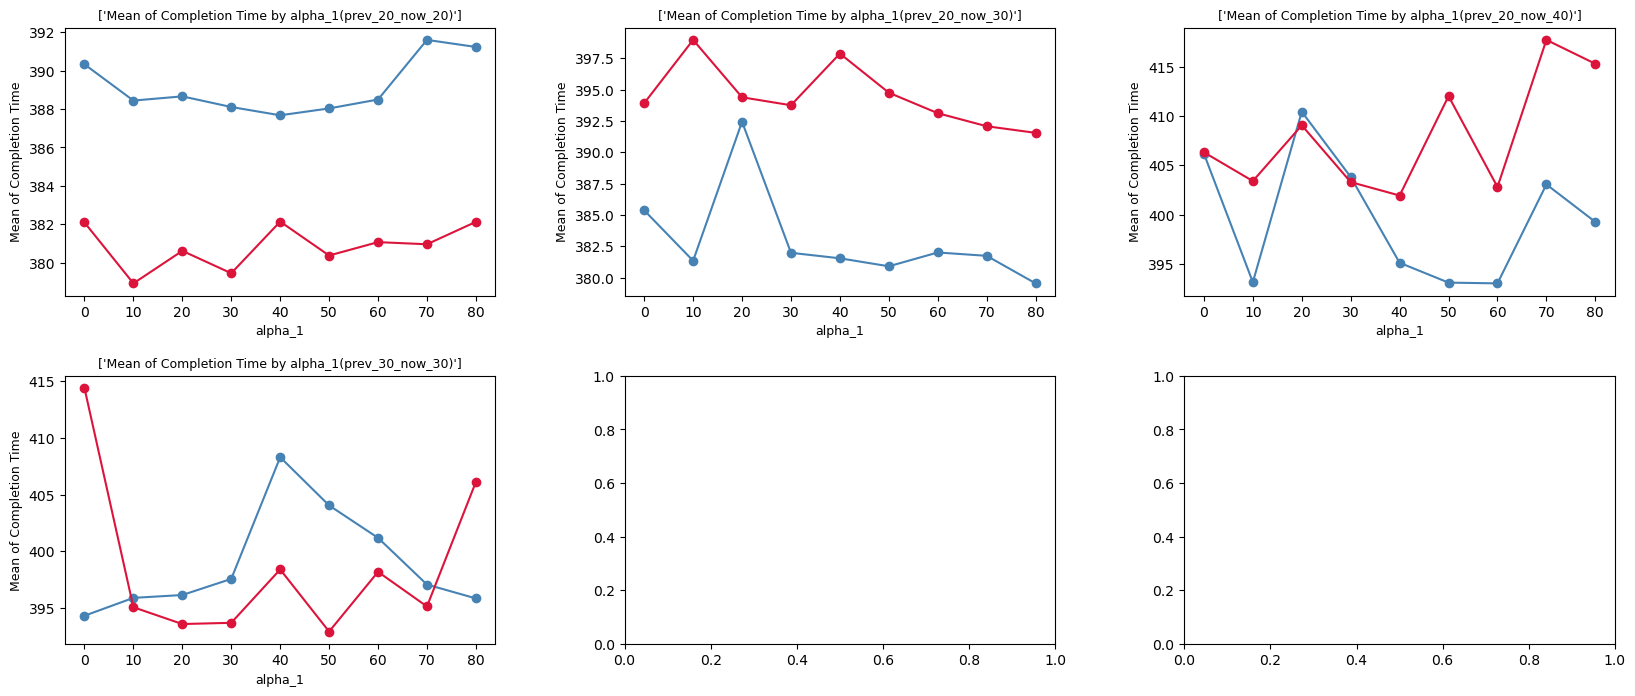

In [176]:
dfs = [prev_20_now_20_data_mean_df, prev_20_now_30_data_mean_df, prev_20_now_40_data_mean_df, prev_30_now_30_data_mean_df]
x_label = "alpha_1"
y_label = "Mean of Completion Time"
title = "Mean of Completion Time by alpha_1"

x_col_name = "alpha_1"
y_col_name = "mean Completion Time"

Create_subplot(dfs, x_label, y_label, title, x_col_name, y_col_name, 2, 3, (20, 8))